In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.io as sio
import scipy.stats as stats
from sklearn.linear_model import Ridge

In [13]:
def get_partition(total, test_frac=0.2, return_bool_mask=False):
    num_total = total
    num_samples = int(test_frac*num_total)
    sample_frac = np.random.choice(num_total,num_samples,replace=False)
    bool_frac = np.bincount(sample_frac,minlength=num_total).astype(np.bool)
    if return_bool_mask:
        return (~bool_frac,bool_frac)
    else:
        return (np.arange(num_total)[bool_frac],np.arange(num_total)[~bool_frac])

def ridge_regression(x,y,validation_frac=1.0/7,alpha=1.0):
    num_samples = x.shape[0]
    num_cells = y.shape[1]
    
    train_idx,test_idx = get_partition(num_samples,validation_frac,True)
    
    x_train,x_test = x[train_idx], x[test_idx]
    y_train,y_test = y[train_idx], y[test_idx]
    num_test = y_test.shape[0]
    
    clf = Ridge(alpha=alpha)
    clf.fit(x_train,y_train)
    
    y_pred = clf.predict(x_test)
    
    r_eval = [stats.pearsonr(y_pred[:,i],y_test[:,i])[0] for i in np.arange(num_cells)]
    
    return np.array(r_eval)

# Load data

In [14]:
gabor = sio.loadmat('/home/elijahc/dev/sparse_Gabors_for_Will/01_gabor_activations.mat')['Y']
gabor = np.swapaxes(gabor,0,1)
gabor.shape

(270, 1089)

In [15]:
v1_data_path = '/home/elijahc/dev/v1_predictor/data/'
filename = '02mean50ms_smallim_d2_crop.mat'
rates = sio.loadmat(os.path.join(v1_data_path,filename))['activity']
print(rates.shape)

(270, 37)


## Sample alphas in logspace
range: $10^{-2}$ to $10^{2}$

In [50]:
alphas = np.logspace(1,8,25)

In [51]:
r_eval_trials = []
for t in np.arange(7):
    r_eval_trials.append(np.concatenate([ridge_regression( x=gabor, y=rates, alpha=a ).reshape(-1,1) for a in alphas],axis=1))

In [52]:
r_eval.shape

(37, 10)

In [53]:
# Store data tidy format for pandas
n_neurons, n_alphas = r_eval.shape
recs = []
for t, r_eval in enumerate(r_eval_trials):
    for i in np.arange(n_neurons):
        for j in np.arange(n_alphas):
            recs.append(dict(
                neuron=i,
                alpha=np.round(alphas[j],decimals=3),
                r_eval=r_eval[i,j],
                dataset='02',
                trial=t+1
            ))

rr_opt_df = pd.DataFrame.from_records(recs)
rr_opt_df.head()

,alpha,dataset,neuron,r_eval,trial
0,10.000,02,0,0.410851,1
1,19.573,02,0,0.291134,1
2,38.312,02,0,0.477912,1
3,74.989,02,0,0.456743,1
4,146.780,02,0,0.394907,1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

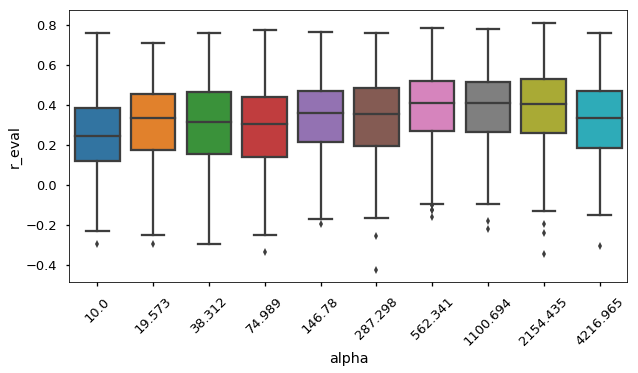

In [54]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax = sns.boxplot(x='alpha',y='r_eval',data=rr_opt_df,ax=ax)
plt.xticks(rotation=45)